# Multi class object detection by TRANSFER LEARNING

# Preparing Data

### Importing necessary libraries

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
from keras.utils.vis_utils import plot_model

### Defining paths 

In [ ]:
IMAGES_PATH = '/content/drive/MyDrive/dataset/caltech/images'
ANNOTS_PATH = '/content/drive/MyDrive/dataset/caltech/annotations'
STORAGE_PATH = '/content/drive/MyDrive/dataset/storage/'

 ### Initialize our initial learning rate, number of epochs to train for, and the batch size

In [ ]:
INIT_LR = 1e-4
NUM_EPOCHS = 50
BATCH_SIZE = 8

In [ ]:
# initialize the list of data (images), class labels, target bounding box coordinates, and image paths
data = []
labels = []
bboxes = []
image_paths = []

In [ ]:
# loop over all CSV files in the annotations directory
for path in paths.list_files(ANNOTS_PATH, validExts=(".csv")):
  
	  # load the contents of the current CSV annotations file
    rows = open(path).read().strip().split("\n")

    # loop over the rows
    for i,row in enumerate(rows):
        
        if (i==1):
            print(row)
        
        # break the row into the filename, bounding box coordinates, and class label
        if(i==0):
            continue
        row = row.split(",")
        (_,filename, startY, endY, startX, endX, label) = row

        # declaring the path to the input image and loading the image in OpenCV format, and grab its dimensions
        image_path = os.path.sep.join([IMAGES_PATH, label, filename])
        image = cv2.imread(image_path)
        (h, w) = image.shape[:2]

	    	# scale the bounding box coordinates relative to the spatial dimensions of the input image
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h

        # load the image (with size compatibility of vgg model) and preprocess it
        image = load_img(image_path, target_size=(224, 224)) 
        image = img_to_array(image)

        # appendng the image, labels, bounding boxes and image paths into an array
        data.append(image)
        labels.append(label)
        bboxes.append((startX, startY, endX, endY))
        image_paths.append(image_path)


0,image_0044.jpg,3.0,242.0,50.0,239.0,elephant
0,image_0018.jpg,38.0,277.0,2.0,220.0,cellphone
0,image_0048.jpg,64.0,128.0,58.0,219.0,car_side
0,image_0039.jpg,30.0,287.0,7.0,262.0,soccer_ball


In [ ]:
# converting the image data into numpy format and changing its range from [0, 255] to [0, 1]
# also converting labels, bounding boxes and image_path into numpy array

data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
image_paths = np.array(image_paths)

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)


In [ ]:
labels

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [ ]:
# partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing
partitioned_data = train_test_split(data, labels, bboxes, image_paths, test_size=0.20, random_state=42)

# unpack the data partitioned_data
(trainImages, testImages) = partitioned_data[:2]
(trainLabels, testLabels) = partitioned_data[2:4]
(trainBBoxes, testBBoxes) = partitioned_data[4:6]
(trainPaths, testPaths) = partitioned_data[6:]

In [ ]:
print(trainImages.shape)
print(testImages.shape)

(248, 224, 224, 3)
(62, 224, 224, 3)


### Defining VGG model

In [ ]:
# load the VGG16 model with imagenet weights and excluding the top fully connected layer
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


# freezing all the layers of VGG model as we are performing transfer learning
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# constructed a branch of fully connected layer for bounding box prediction
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",	name="bounding_box")(bboxHead)

# constructed a branch of fully connected layer for class label prediction
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",	name="class_label")(softmaxHead)


# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(inputs=vgg.input,	outputs=(bboxHead, softmaxHead))


# define a dictionary to set the loss methods

# 1) categorical cross-entropy for the class label branch 
# 2) mean absolute error for the bounding box branch

losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}

# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}

# initializing adam optimizer and compiling the model
opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)

# model summary
print(model.summary())



# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}


# construct a dictionary for our target testing outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}




58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_____________________________

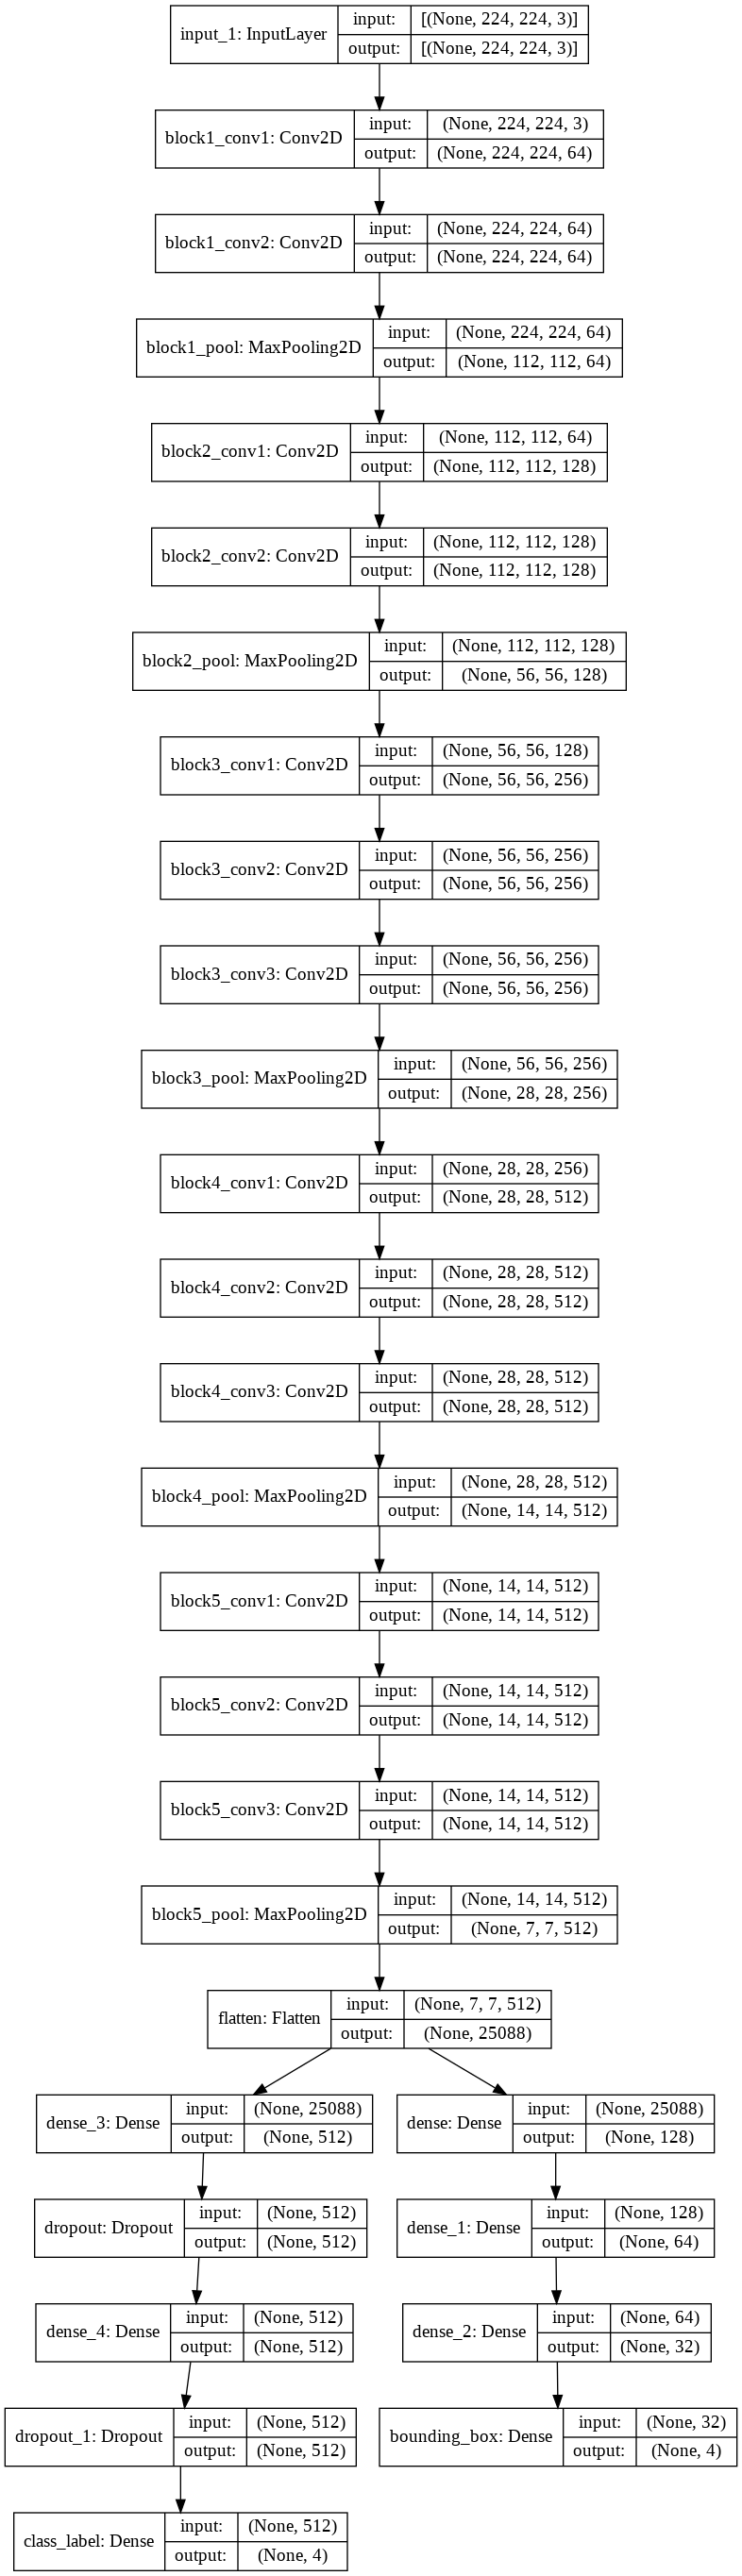

In [ ]:
plot_model(model, to_file = STORAGE_PATH +'model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# train the network for bounding box regression and class label prediction

H = model.fit(trainImages, trainTargets,validation_data=(testImages, testTargets),batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,	verbose=1)




Epoch 1/50
31/31 [==============================] - 38s 129ms/step - loss: 1.1072 - bounding_box_loss: 0.0213 - class_label_loss: 1.0859 - bounding_box_accuracy: 0.2896 - class_label_accuracy: 0.5375 - val_loss: 0.1311 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.1229 - val_bounding_box_accuracy: 0.7742 - val_class_label_accuracy: 1.0000
Epoch 2/50
31/31 [==============================] - 2s 59ms/step - loss: 0.1525 - bounding_box_loss: 0.0055 - class_label_loss: 0.1469 - bounding_box_accuracy: 0.7581 - class_label_accuracy: 0.9606 - val_loss: 0.0581 - val_bounding_box_loss: 0.0062 - val_class_label_loss: 0.0519 - val_bounding_box_accuracy: 0.7903 - val_class_label_accuracy: 0.9839
Epoch 3/50
31/31 [==============================] - 2s 59ms/step - loss: 0.0693 - bounding_box_loss: 0.0037 - class_label_loss: 0.0656 - bounding_box_accuracy: 0.7641 - class_label_accuracy: 0.9885 - val_loss: 0.0566 - val_bounding_box_loss: 0.0057 - val_class_label_loss: 0.0509 - val_bounding_b

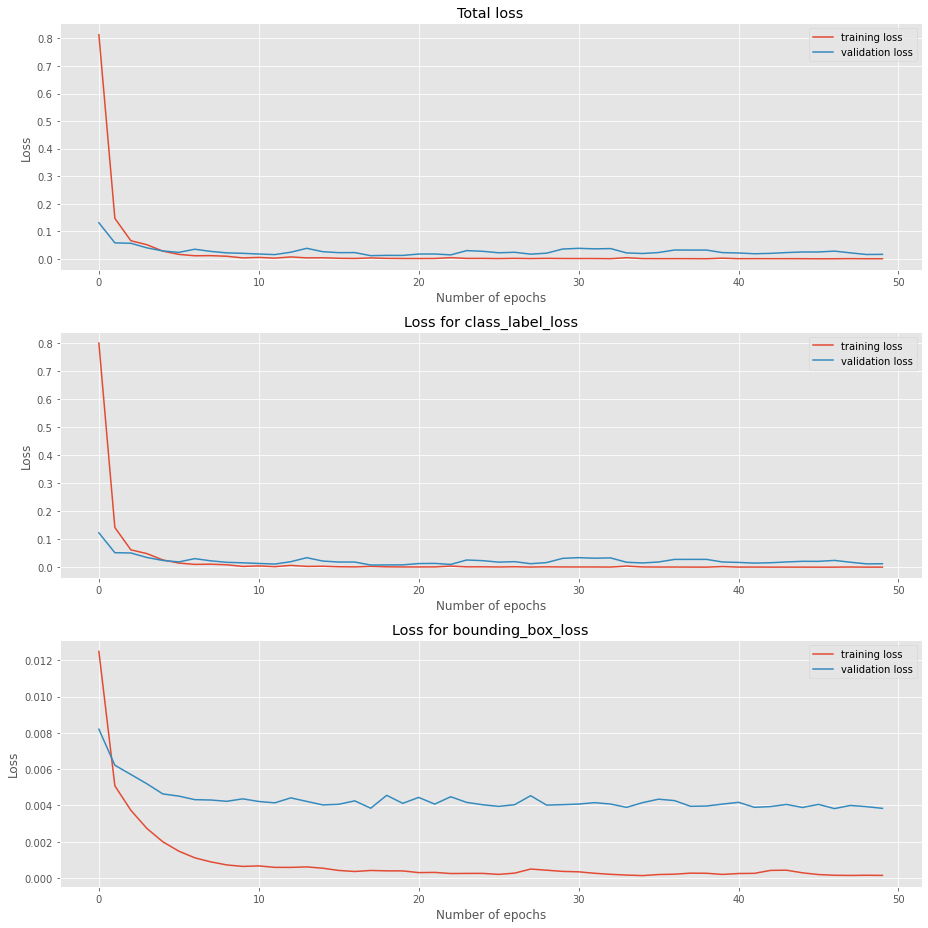

In [ ]:
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names

for (i, l) in enumerate(lossNames):

    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Number of epochs")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label="training loss")
    ax[i].plot(N, H.history["val_" + l], label="validation loss")
    ax[i].legend()


# saving the plot
plt.tight_layout()
plotPath = STORAGE_PATH + "losses12.png"
plt.savefig(plotPath)
plt.show()
plt.close()

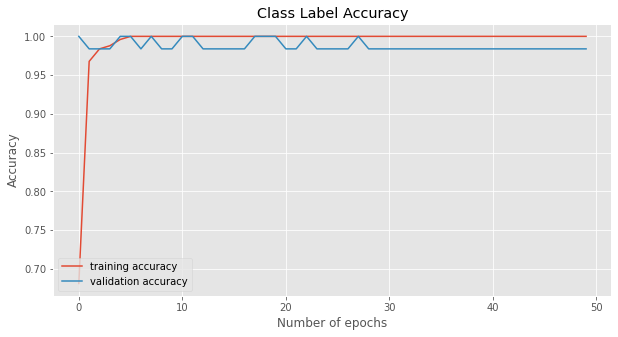

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
plt.style.use("ggplot")
plt.figure()

plt.plot(N, H.history["class_label_accuracy"], label="training accuracy")
plt.plot(N, H.history["val_class_label_accuracy"],	label="validation accuracy")
plt.title("Class Label Accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plotPath = STORAGE_PATH + "accuracy_class_label1.png"
plt.savefig(plotPath)
plt.show()

plt.close()

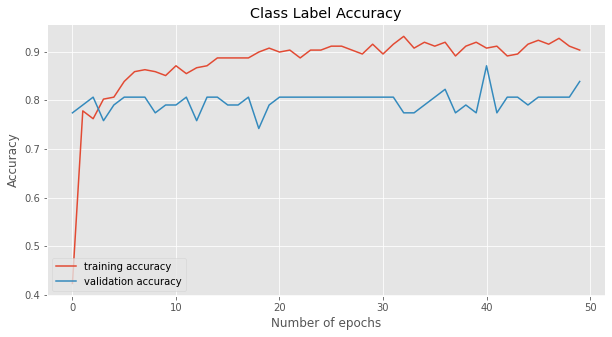

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
plt.style.use("ggplot")
plt.figure()


plt.plot(N, H.history["bounding_box_accuracy"], label="training accuracy")
plt.plot(N, H.history["val_bounding_box_accuracy"],	label="validation accuracy")
plt.title("Class Label Accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# plt.show()
plotPath = STORAGE_PATH + "accuracy_bounding_box1.png"
plt.savefig(plotPath)
plt.show()

plt.close()

# Predictions

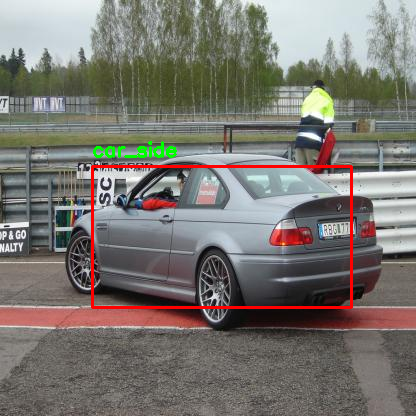

In [ ]:
imagePath = "/content/drive/MyDrive/dataset/train/0f7f3b82ff9db6e8_jpg.rf.55fc681b986a9c6e1c561b40318e97d2.jpg"
image = load_img(imagePath, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)


(boxPreds, labelPreds) = model.predict(image)
(startX_, startY_, endX_, endY_) = boxPreds[0]
i = np.argmax(labelPreds, axis=1)
label = lb.classes_[i][0]



from google.colab.patches import cv2_imshow
image = cv2.imread(imagePath)
# image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
# scale the predicted bounding box coordinates based on the image
# dimensions
startX_ = int(startX_ * w)
startY_ = int(startY_ * h)
endX_ = int(endX_ * w)
endY_ = int(endY_ * h)
color = (0, 0, 255)
  
# Line thickness of 2 px
thickness = 2
# draw the predicted bounding box and class label on the image
y = startY_ - 10 if startY_ - 10 > 10 else startY_ + 10
image = cv2.putText(image, label, (startX_, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
# image = cv2.rectangle(image, (startX_, startY_), (endX, endY), color, thickness)

start_point = (int(startX_),int(startY_))
end_point = (int(endX_),int(endY_))


image = cv2.rectangle(image, start_point, end_point, color, thickness)
# show the output image
cv2_imshow(image)

